In [1]:
from gerrychain import Graph

In [2]:
# Read Iowa county graph from the json file "IA_county.json"
filepath = 'C:\\Users\\antay\\Downloads\\IA\\'
filename = 'IA_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [3]:
# For each node, print the node #, county name, and its population
for node in G.nodes:
    county_name = G.nodes[node]['NAME20']
    county_population = G.nodes[node]['P0010001']
    G.nodes[node]['TOTPOP'] = county_population
    print("Node",node,"represents",county_name,"County, which had a population of",county_population,"in the 2020 census.")

Node 0 represents Wright County, which had a population of 12943 in the 2020 census.
Node 1 represents Montgomery County, which had a population of 10330 in the 2020 census.
Node 2 represents Union County, which had a population of 12138 in the 2020 census.
Node 3 represents Keokuk County, which had a population of 10033 in the 2020 census.
Node 4 represents Story County, which had a population of 98537 in the 2020 census.
Node 5 represents Mitchell County, which had a population of 10565 in the 2020 census.
Node 6 represents Grundy County, which had a population of 12329 in the 2020 census.
Node 7 represents Winneshiek County, which had a population of 20070 in the 2020 census.
Node 8 represents Polk County, which had a population of 492401 in the 2020 census.
Node 9 represents Sac County, which had a population of 9814 in the 2020 census.
Node 10 represents Marshall County, which had a population of 40105 in the 2020 census.
Node 11 represents Delaware County, which had a population 

In [4]:
# Let's impose a 2% population deviation (+/-1%)
# (Usually, we use 1% deviation, but this instance is infeasible at 1%.)
deviation = 0.02

k = 4  # desired number of districts
total_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes )
ideal_population = total_population / k

import math
L = math.ceil( ( 1 - deviation / 2 ) * ideal_population )
U = math.floor( ( 1 + deviation / 2 ) * ideal_population )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 789617 and U = 805568 and k = 4


In [5]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars( G.nodes, k, vtype=GRB.BINARY ) # x[i,j] = 1 if county i is assigned to district j
y = m.addVars( G.edges, vtype=GRB.BINARY )    # y[u,v] = 1 when edge {u,v} is cut

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-14


In [6]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

## Equivalently, we could write:
#m.setObjective( gp.quicksum( y ), GRB.MINIMIZE )

In [7]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k) ) == 1 for i in G.nodes )

# add constraints saying that each district has a population at least L and at most U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k) )

m.update()

In [8]:
# solve IP model
m.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-6700HQ CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 995 rows, 618 columns and 3852 nonzeros
Model fingerprint: 0xc3b5bfc4
Variable types: 0 continuous, 618 integer (618 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Found heuristic solution: objective 159.0000000
Presolve time: 0.01s
Presolved: 995 rows, 618 columns, 3852 nonzeros
Variable types: 0 continuous, 618 integer (618 binary)

Root relaxation: objective 0.000000e+00, 623 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  396  159.00000    0.00000   1

 151792 21559   30.94769   29  389   32.00000   28.18918  11.9%   121  331s
 154327 21270     cutoff   32        32.00000   28.26335  11.7%   120  336s
 156740 20990     cutoff   29        32.00000   28.32453  11.5%   120  341s
 159294 20652     cutoff   27        32.00000   28.38821  11.3%   120  345s
 161666 20319     cutoff   31        32.00000   28.44709  11.1%   120  350s
 165179 19818   30.79636   29  249   32.00000   28.53717  10.8%   119  356s
 167521 19410   29.74069   29  355   32.00000   28.59317  10.6%   119  360s
 169943 18942   29.99709   38  223   32.00000   28.65822  10.4%   119  365s
 173340 18310     cutoff   34        32.00000   28.74847  10.2%   119  370s
 175923 17807   30.83200   31  317   32.00000   28.80832  10.0%   119  375s
 178366 17383   30.24617   32  271   32.00000   28.88526  9.73%   118  380s
 181170 16583   29.87529   35  234   32.00000   28.95946  9.50%   118  386s
 183573 15945   30.14705   30  348   32.00000   29.03676  9.26%   118  390s
 186017 1524

In [9]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in range(k) ]
district_county_names = [ [ G.nodes[i]['NAME20'] for i in district ] for district in districts ]
district_populations = [ sum( G.nodes[i]['TOTPOP'] for i in district ) for district in districts ]

# print district info
for j in range(k):
    print("District",j,"has these nodes =",districts[j],"and this population =",district_populations[j] )
    print("The corresponding county names are =",district_county_names[j] )
    print("")

The number of cut edges is 32.0
District 0 has these nodes = [0, 1, 2, 9, 14, 19, 20, 21, 22, 23, 27, 30, 31, 32, 33, 35, 37, 40, 41, 42, 43, 48, 52, 53, 55, 57, 58, 59, 60, 62, 63, 64, 65, 66, 68, 70, 71, 73, 76, 78, 79, 81, 84, 89, 91, 92] and this population = 794167
The corresponding county names are = ['Wright', 'Montgomery', 'Union', 'Sac', 'Audubon', 'Plymouth', 'Pottawattamie', 'Taylor', 'Page', 'Cherokee', 'Fremont', 'Emmet', 'Woodbury', 'Clay', 'Crawford', 'Osceola', 'Greene', 'Lyon', 'Adams', 'Monona', 'Humboldt', 'Lucas', "O'Brien", 'Guthrie', 'Sioux', 'Winnebago', 'Ida', 'Cass', 'Decatur', 'Carroll', 'Pocahontas', 'Kossuth', 'Harrison', 'Webster', 'Madison', 'Palo Alto', 'Ringgold', 'Calhoun', 'Clarke', 'Warren', 'Adair', 'Hancock', 'Shelby', 'Dickinson', 'Buena Vista', 'Mills']

District 1 has these nodes = [4, 6, 8, 10, 16, 17, 49, 93] and this population = 801682
The corresponding county names are = ['Story', 'Grundy', 'Polk', 'Marshall', 'Hardin', 'Boone', 'Hamilton', 

In [10]:
import networkx as nx
for district in districts:
    print("Is district =", district, "connected?", nx.is_connected( G.subgraph( district ) ) )

Is district = [0, 1, 2, 9, 14, 19, 20, 21, 22, 23, 27, 30, 31, 32, 33, 35, 37, 40, 41, 42, 43, 48, 52, 53, 55, 57, 58, 59, 60, 62, 63, 64, 65, 66, 68, 70, 71, 73, 76, 78, 79, 81, 84, 89, 91, 92] connected? True
Is district = [4, 6, 8, 10, 16, 17, 49, 93] connected? True
Is district = [5, 7, 11, 13, 15, 29, 34, 36, 45, 50, 51, 56, 69, 74, 75, 77, 80, 82, 85, 87, 88, 90] connected? True
Is district = [3, 12, 18, 24, 25, 26, 28, 38, 39, 44, 46, 47, 54, 61, 67, 72, 83, 86, 94, 95, 96, 97, 98] connected? True


In [11]:
# Let's draw it on a map
import geopandas as gpd

In [12]:
# Read Iowa county shapefile from "IA_county.shp"
filepath = 'C:\\Users\\antay\\Downloads\\IA\\'
filename = 'IA_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

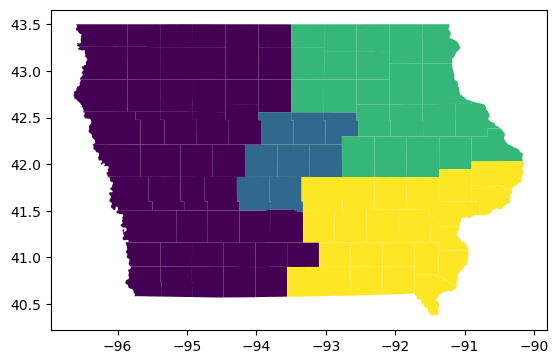

In [13]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]
labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()